### Import các thư viện, đọc dữ liệu từ file và xem nhanh dữ liệu ở 5 dòng đầu tiên

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_excel("HousePricePrediction.xlsx")

dataset.head(5)


,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


### Xem số cột và số dòng của bộ dữ liệu

In [3]:
dataset.shape

(2919, 13)

### Xem số lượng cột có kiểu dữ liệu object, int64 và float64

In [4]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float64')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 4
Integer variables: 6
Float variables: 3


### Chọn các dữ liệu số để vẽ heatmap để phân tích sự tương quan

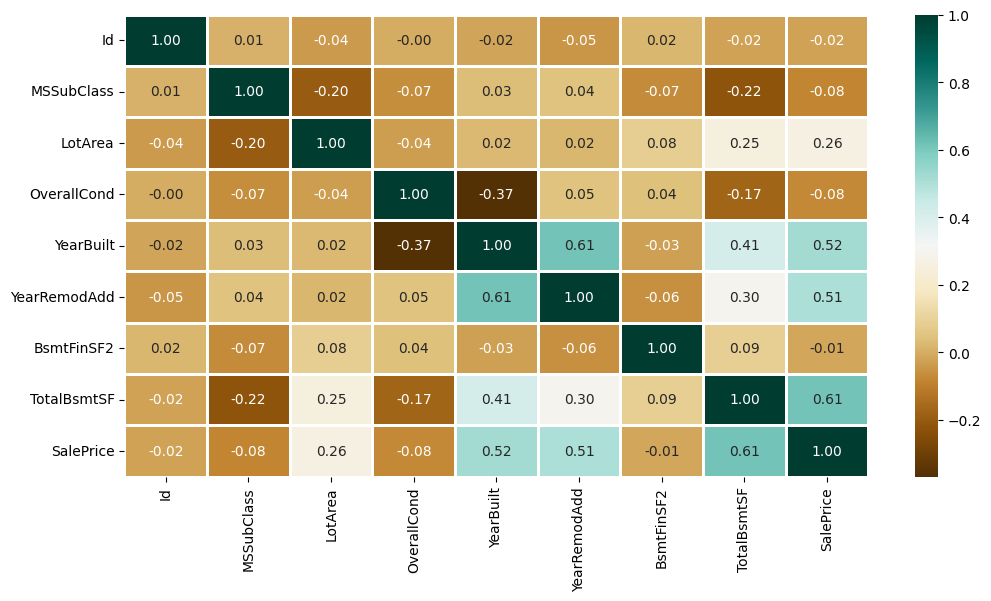

In [5]:
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(), cmap = 'BrBG', fmt = '.2f', linewidths = 2, annot = True);

#### Đếm số giá trị duy nhất trong mỗi cột phân loại (Categorical Variables) và vẽ chúng lên

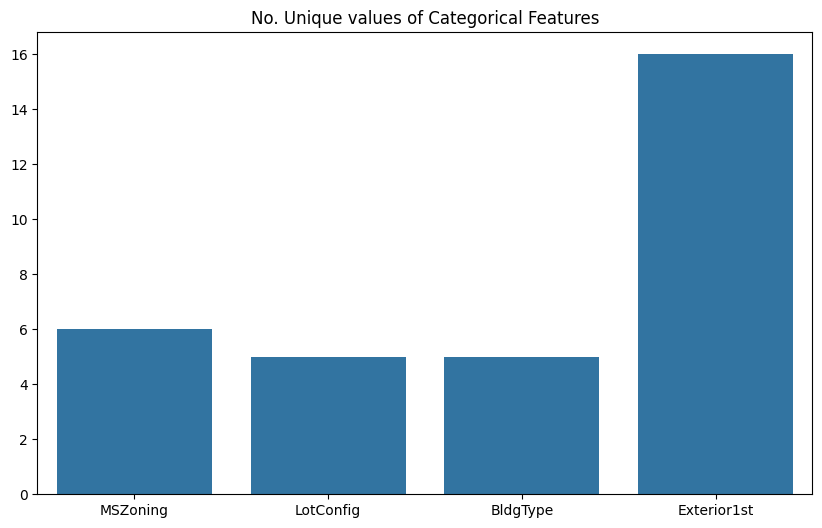

In [6]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
sns.barplot(x=object_cols,y=unique_values);

#### Phần vẽ biểu đồ phân phối dữ liệu

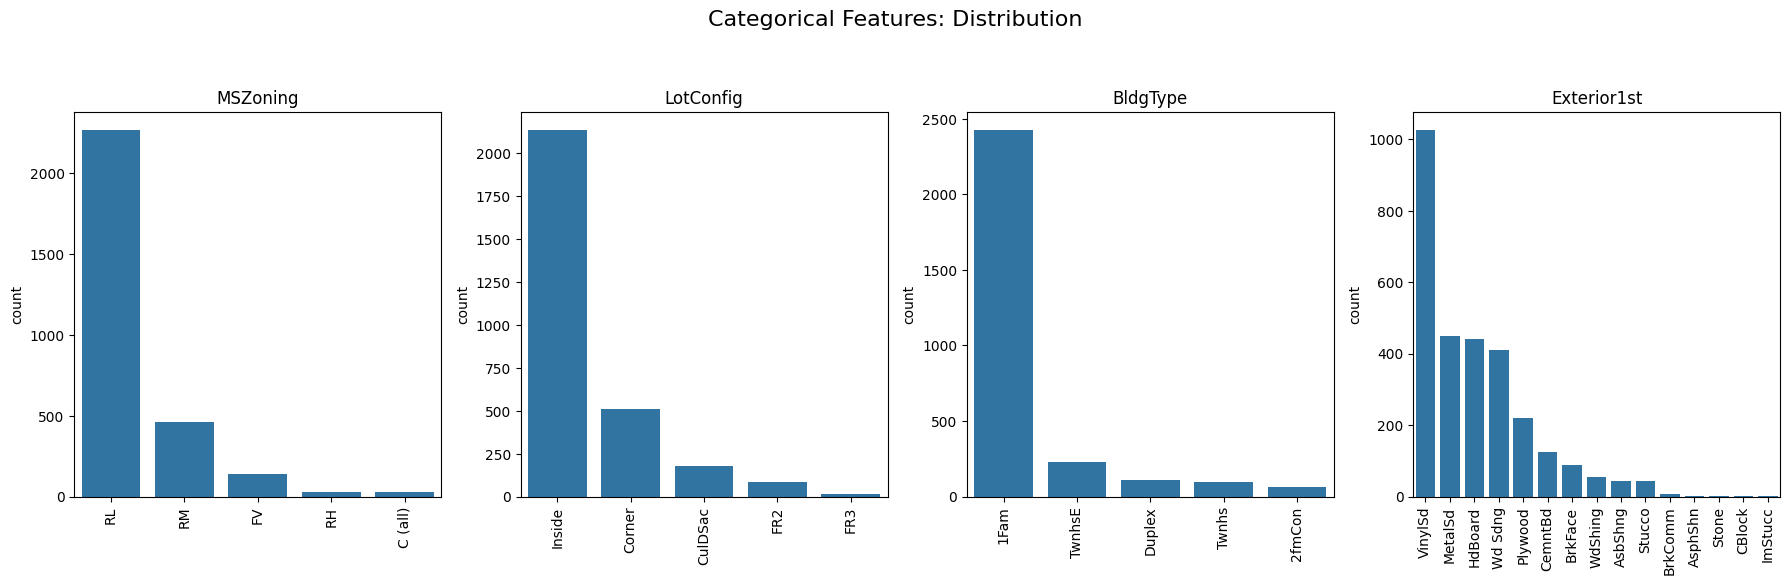

In [7]:
fig, axes = plt.subplots(
    nrows=(len(object_cols) // 4) + 1, ncols=4, figsize=(18, 10)
)  # Tạo các subplot
axes = axes.flatten()  # Biến đổi mảng 2D thành 1D

# Vẽ các biểu đồ
for index, col in enumerate(object_cols):
    y = dataset[col].value_counts()
    sns.barplot(x=list(y.index), y=y, ax=axes[index])
    axes[index].set_title(col)  # Tiêu đề riêng cho từng biểu đồ
    axes[index].tick_params(axis='x', rotation=90)  # Xoay nhãn trục x

# Ẩn các ô trống nếu số cột không chia hết
for i in range(index + 1, len(axes)):
    axes[i].set_visible(False)

# Đặt tiêu đề tổng cho toàn bộ biểu đồ
fig.suptitle('Categorical Features: Distribution', fontsize=16)

# Điều chỉnh khoảng cách giữa các subplot và tiêu đề
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Chừa không gian cho tiêu đề
plt.show()

#### Xoá cột ID ra khỏi dataset

In [8]:
dataset.drop(['Id'], axis=1, inplace=True)

#### Thay thế các giá trị thiếu (NaN) trong cột SalePrice bằng giá trị trung bình của cột đó

In [9]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(
  dataset['SalePrice'].mean())

#### tạo ra một DataFrame mới new_dataset bằng cách loại bỏ tất cả các hàng có chứa giá trị thiếu từ DataFrame dataset.

In [10]:
new_dataset = dataset.dropna()

In [12]:
new_dataset.isnull().sum()

MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

#### xác định và in ra danh sách các cột phân loại (kiểu dữ liệu object) trong DataFrame new_dataset và số lượng của chúng.

In [13]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
      len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


#### mã hóa các cột phân loại trong new_dataset bằng phương pháp One-Hot Encoding và kết hợp chúng với các cột số để tạo ra DataFrame cuối cùng df_final.

In [14]:
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

# This code is modified by Susobhan Akhuli

#### chia dữ liệu thành các tập huấn luyện và kiểm tra để chuẩn bị cho quá trình huấn luyện và đánh giá mô hình.

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into 
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

#### huấn luyện một mô hình Support Vector Regression (SVR) trên tập dữ liệu huấn luyện, dự đoán giá trị trên tập dữ liệu kiểm tra và tính toán lỗi phần trăm tuyệt đối trung bình của các dự đoán.

In [16]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1870512931870423


#### huấn luyện một mô hình Random Forest Regressor trên tập dữ liệu huấn luyện, dự đoán giá trị trên tập dữ liệu kiểm tra và tính toán lỗi phần trăm tuyệt đối trung bình của các dự đoán.

In [17]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)

0.19273880752721087

#### huấn luyện một mô hình hồi quy tuyến tính trên tập dữ liệu huấn luyện, dự đoán giá trị trên tập dữ liệu kiểm tra và tính toán lỗi phần trăm tuyệt đối trung bình của các dự đoán.

In [18]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.187416838415999


#### huấn luyện một mô hình CatBoost Regressor trên tập dữ liệu huấn luyện, dự đoán giá trị trên tập dữ liệu kiểm tra và tính toán hệ số xác định (R² score) của các dự đoán.

In [19]:
# This code is contributed by @amartajisce
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

cb_model = CatBoostRegressor()
cb_model.fit(X_train, Y_train)
preds = cb_model.predict(X_valid) 

cb_r2_score=r2_score(Y_valid, preds)
cb_r2_score

# This code is modified by Susobhan Akhuli

Learning rate set to 0.046797
0:	learn: 56473.5753002	total: 153ms	remaining: 2m 32s
1:	learn: 55780.1567575	total: 154ms	remaining: 1m 16s
2:	learn: 55060.9599505	total: 155ms	remaining: 51.5s
3:	learn: 54456.1126921	total: 156ms	remaining: 38.9s
4:	learn: 53901.1464265	total: 158ms	remaining: 31.4s
5:	learn: 53334.6062357	total: 159ms	remaining: 26.4s
6:	learn: 52824.4943646	total: 160ms	remaining: 22.8s
7:	learn: 52381.4267520	total: 162ms	remaining: 20.1s
8:	learn: 51841.0364316	total: 163ms	remaining: 18s
9:	learn: 51281.5852560	total: 165ms	remaining: 16.3s
10:	learn: 50825.3817438	total: 166ms	remaining: 14.9s
11:	learn: 50477.2609796	total: 168ms	remaining: 13.8s
12:	learn: 50081.4097641	total: 169ms	remaining: 12.8s
13:	learn: 49663.6380360	total: 170ms	remaining: 12s
14:	learn: 49334.5782662	total: 171ms	remaining: 11.3s
15:	learn: 48967.5221026	total: 173ms	remaining: 10.6s
16:	learn: 48676.4063222	total: 175ms	remaining: 10.1s
17:	learn: 48359.1169955	total: 176ms	remaining

0.38351169878113034